In [51]:
import torch
import torch.autograd.functional as F
import torch.distributions as dist
import jax.numpy as jnp
import jax

%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

### Derivative

In [52]:
def f1(x):
    return 3*x**2

x = torch.tensor(2.0, requires_grad=True)


# Torch version 1 (using .backward)
z = f1(x)
z.backward()
print("Using backwards in torch", x.grad)

# Torch version 2 (using autograd.grad)
print("Using autograd.grad in torch", torch.autograd.grad(f1(x), x)[0])

# Jax version
print("Using grad in jax", jax.grad(f1)(jnp.array(2.0)))


Using backwards in torch tensor(12.)
Using autograd.grad in torch tensor(12.)
Using grad in jax 12.0


In [53]:
### Partial Derivative

def f2(x, y):
    return 2*x**2 + 3*y
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(1.5, requires_grad=True)

# Torch version 1 (using .backward)
z = f2(x, y)
z.backward()
print("\nUsing Method 1 Torch")
print("Partial wrt x: ", x.grad)
print("Partial wrt y: ", y.grad)


# Torch version 2 (using autograd.grad)
print("\nUsing Method 2 Torch")
print("Partial wrt x: ", torch.autograd.grad(f2(x, y), x)[0])
print("Partial wrt y: ", torch.autograd.grad(f2(x, y), y)[0])

# Jax version
print("\nUsing Jax")
print("Partial wrt x: ", jax.grad(f2, argnums=0)(jnp.array(2.0), jnp.array(1.5)))
print("Partial wrt y: ", jax.grad(f2, argnums=1)(jnp.array(2.0), jnp.array(1.5)))



Using Method 1 Torch
Partial wrt x:  tensor(8.)
Partial wrt y:  tensor(3.)

Using Method 2 Torch
Partial wrt x:  tensor(8.)
Partial wrt y:  tensor(3.)

Using Jax
Partial wrt x:  8.0
Partial wrt y:  3.0


### Gradient


In [54]:
# Torch version 1 (using .backward)
grad_f2_v1 = torch.tensor([x.grad, y.grad])
print("\nUsing Method 1 Torch")
print(grad_f2_v1)
# Torch version 2 (using autograd.grad)
grad_f2_v2 = torch.tensor(torch.autograd.grad(f2(x, y), (x, y)))
print("\nUsing Method 2 Torch")
print(grad_f2_v2)

# Jax version
grad_f2_jax = jax.grad(f2, argnums=[0, 1])(jnp.array(2.0), jnp.array(1.5))
print("\nUsing Jax")
print(grad_f2_jax)


Using Method 1 Torch
tensor([8., 3.])

Using Method 2 Torch
tensor([8., 3.])

Using Jax
(Array(8., dtype=float32, weak_type=True), Array(3., dtype=float32, weak_type=True))


In [55]:
### Jacobian

# We take the Jacobian of the function f(x, y) = [x**2 + y**2, x - y]
# The Jacobian analytically is [[2x, 2y], [1, -1]]
def f1(x, y):
        return x**2 + y**2
def f2(x, y):
        return x - y

def f(x, y):
    return torch.stack([f1(x, y), f2(x, y)])

x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(1.0, requires_grad=True)

z = f(x, y)
z

tensor([5., 1.], grad_fn=<StackBackward0>)

If we are to directly call: `z.backward()` we get the following error.

![CleanShot 2023-06-22 at 11.11.12@2x.png](<attachment:CleanShot 2023-06-22 at 11.11.12@2x.png>)

But, `z.backward()` has a parameter called `gradient`

>The graph is differentiated using the chain rule. If the tensor is
non-scalar (i.e. its data has more than one element) and requires
gradient, the function additionally requires specifying ``gradient``.
It should be a tensor of matching type and location, that contains
the gradient of the differentiated function w.r.t. ``self``.
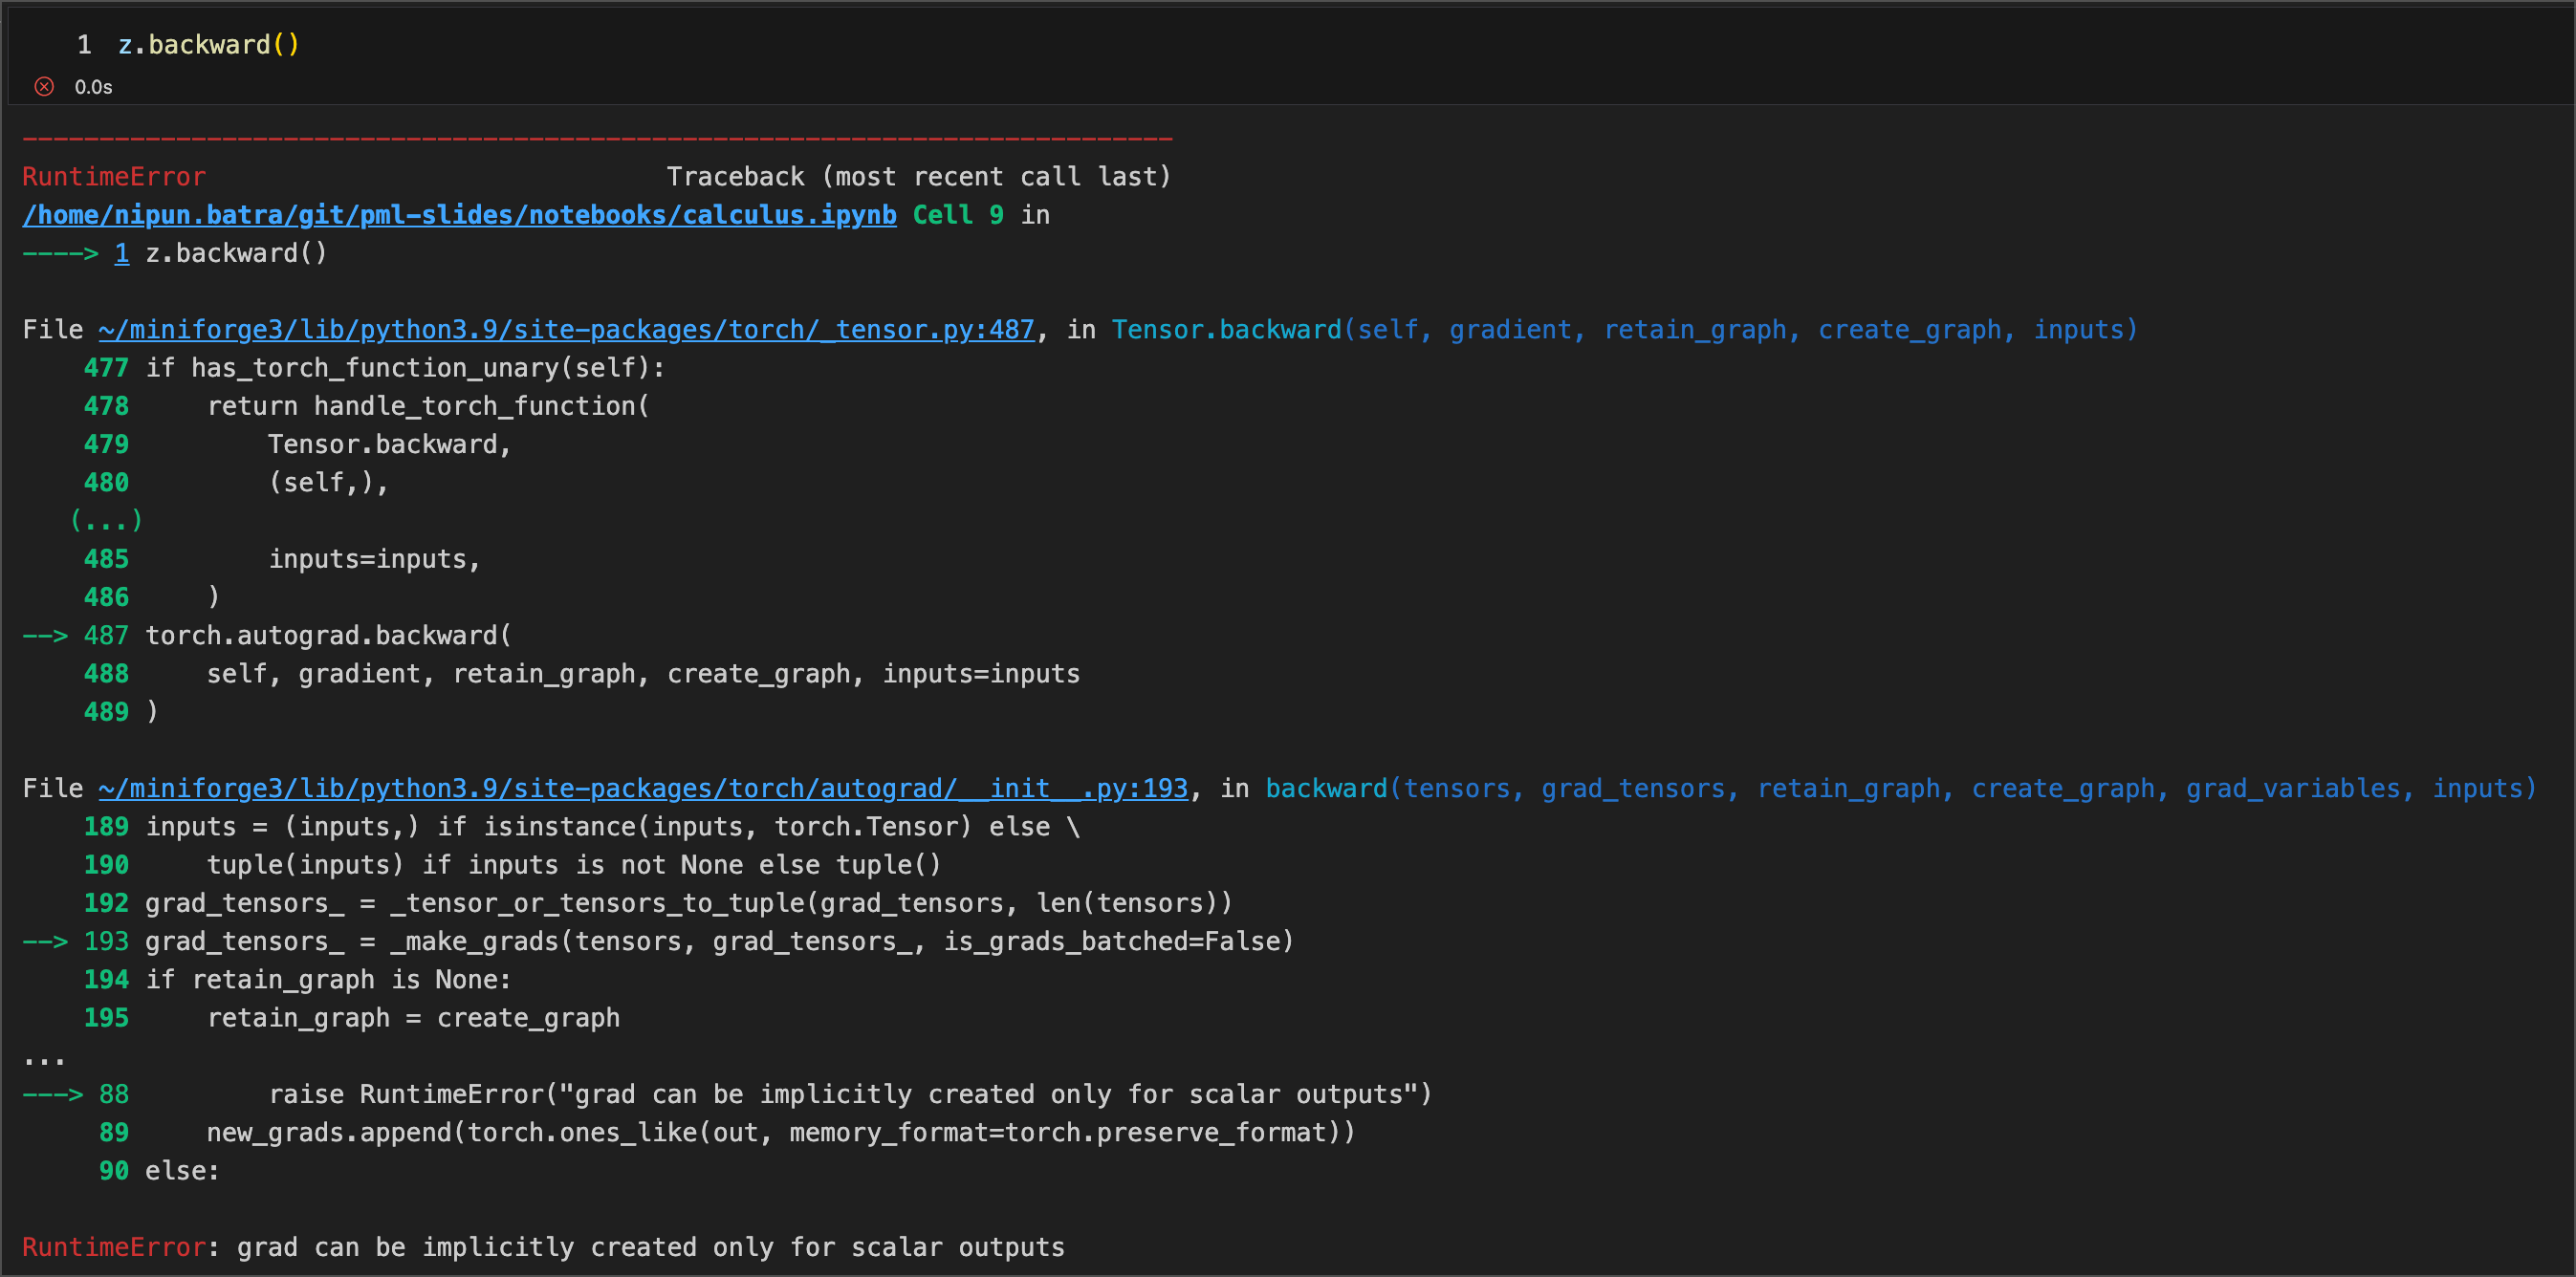

In [56]:
import torch.autograd.functional as F

jacobian = torch.stack(F.jacobian(f, (x, y))).reshape(2, 2)
print("Jacobian:")
print(jacobian)

Jacobian:
tensor([[ 4.,  1.],
        [ 2., -1.]])


In [66]:
# Torch version using autograd.functional.jacobian
print("Jacobian using autograd.functional.jacobian:")
print(torch.stack(F.jacobian(f, (x, y))).reshape(2, 2)) # remove 2, 2 and make it automatic

# Jax version using jax.jacobian
def f_jax(x, y):
    return jnp.stack([f1(x, y), f2(x, y)])

print("Jax Jacobian using jax.jacobian:")
print(jnp.array(jax.jacobian(f_jax, argnums=[0, 1])(jnp.array(2.0), jnp.array(1.0))))

g1 = jnp.array(jax.grad(f1, argnums=[0, 1])(jnp.array(2.0), jnp.array(1.0)))
g2 = jnp.array(jax.grad(f2, argnums=[0, 1])(jnp.array(2.0), jnp.array(1.0)))
print("Jax Jacobian using jax.grad done manually:")
print(jnp.vstack([g1.T, g2.T]).T) # simpler?

# Now we use vmap and grad in Jax to compute the Jacobian (but automatically as opposed to manually done above)







Jacobian using autograd.functional.jacobian:
tensor([[ 4.,  1.],
        [ 2., -1.]])
Jax Jacobian using jax.jacobian:
[[ 4.  1.]
 [ 2. -1.]]
Jax Jacobian using jax.grad done manually:
[[ 4.  1.]
 [ 2. -1.]]


In [ ]:
### Hessian

In [77]:
def f(x, y):
    return x**2 + y**2

x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(1.0, requires_grad=True)

# Torch version using autograd.functional.hessian
print("Hessian using autograd.functional.hessian:")
torch_v1_hessian = torch.tensor(F.hessian(f, (x, y)))
print(torch_v1_hessian)

# Jax version using jax.hessian
jax_hessian = jnp.array(jax.hessian(f, argnums=[0, 1])(jnp.array(2.0), jnp.array(1.0)))
print("Jax Hessian using jax.hessian:")
print(jax_hessian)

# Jax version using jax.jacobian


# Torch version using .backward



Hessian using autograd.functional.hessian:
tensor([[2., 0.],
        [0., 2.]])
Jax Hessian using jax.hessian:
[[2. 0.]
 [0. 2.]]
Jax Hessian using jax.jacobian:


ValueError: Positional argument indices, e.g. for `static_argnums`, must have value greater than or equal to -len(args) and less than len(args), but got value 1 for len(args) == 1.